##Week 6 Homework - Tensorflow and Keras to create GAN 

###Install Tensorflow with version 2.0 GPU
###Check version

In [1]:
#import tensorflow as tf

!pip install tf-nightly-2.0-preview
import tensorflow as tf
print(tf.__version__)



     |████████████████████████████████| 95.2MB 2.8MB/s 
     |████████████████████████████████| 450kB 35.5MB/s 
     |████████████████████████████████| 3.8MB 35.7MB/s 
2.0.0-dev20191002


##Install other requirements

In [2]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


Setup model parameters

In [0]:
TRAIN_BUF=20000
BATCH_SIZE=256
TEST_BUF=4000

Get MNIST-Fashion dataset

In [0]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

Add Train and test parameters

Normalize dataset images

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

Batch to 256 for speed

In [0]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

Check an image

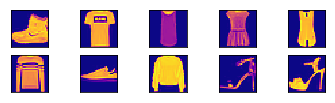

In [117]:
#plt.imshow(train_images[1].reshape(28, 28), cmap='plasma')
#plt.figure(figsize=(28,28))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #plt.imshow(train_images[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.imshow(train_images[i].reshape(28, 28), cmap='plasma')
    #plt.xlabel(class_names[train_labels[i]])
plt.show()

Run the Tensorflow Keras GAN model

In [0]:
class GAN(tf.keras.Model):

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.noise_dim])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )

In [0]:
NOISE_DIM = 100
DIMS = (28,28,1)
# generator / discriminator
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [0]:
# optimize with Adaml
gen_optimizer = tf.keras.optimizers.Adam(0.002, beta_1=0.5)# was 0.001
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model


Run GAN model

In [0]:
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    noise_dim = NOISE_DIM
)

In [0]:
# plotting results after each epoch 
def plot_rebuild(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, NOISE_DIM)))
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap='plasma', vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [0]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

Epoch: 59 | disc_loss: 0.8115560412406921 | gen_loss: 1.5686253309249878


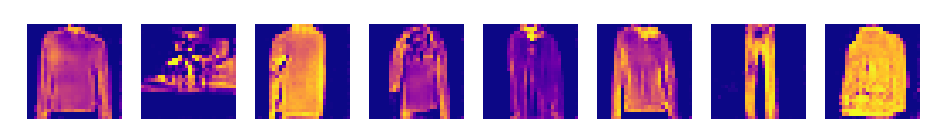

In [126]:
N_TRAIN_BATCHES=64
N_TEST_BATCHES=64

n_epochs = 60
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_rebuild(model)

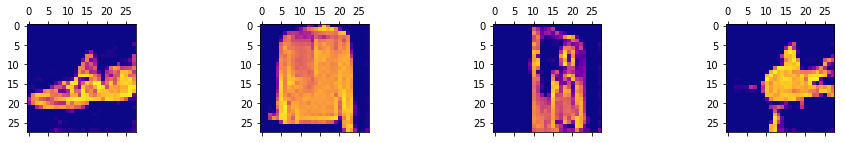

In [135]:
samples1 = model.generate(tf.random.normal(shape=(BATCH_SIZE, NOISE_DIM)))
#samples = model.generate(tf.random.normal(shape=(512, NOISE_DIM)))
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(8 * 2, 2))
for axi in range(4):
    axs[axi].matshow(
                samples1.numpy()[axi].squeeze(), cmap='plasma', vmin=0, vmax=1
            )

plt.show()


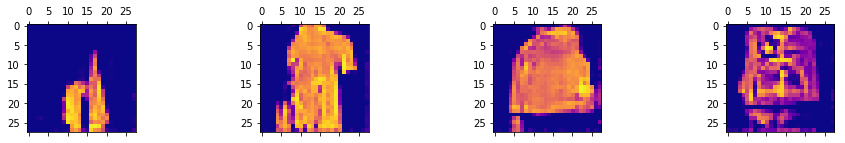

In [142]:
samples1 = model.generate(tf.random.normal(shape=(BATCH_SIZE*4, NOISE_DIM)))
#samples = model.generate(tf.random.normal(shape=(512, NOISE_DIM)))
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(8 * 2, 2))
for axi in range(4):
    axs[axi].matshow(
                samples1.numpy()[axi].squeeze(), cmap='plasma', vmin=0, vmax=1
            )

plt.show()
